## A notebook to validate results from the mesh collisions API

- Get 2 more examples with no collisions visually by n collisions in API
- Make new notebook
- Share all TBs with more than 100% intersection

## Install and import libraries

In [ ]:
%pip install requests pandas seaborn matplotlib.pyplot scipy.spatial.distance sklearn.metrics.pairwise hra_api_client

import requests
import pandas as pd
import seaborn as sns
import json
from pprint import pprint
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import hra_api_client
from hra_api_client.api import v1_api as default_api
from hra_api_client.models.sparql_query_request import SparqlQueryRequest

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for matplotlib.pyplot


## Set global variables

In [10]:
# Get utilities.py
%run ../shared/utilities.py

In [ ]:
# set hra-pop version
hra_pop_version = "v0.10.3"

TypeError: get_as_collision_items() missing 1 required positional argument: 'iri'

## Load data


In [12]:
df_y = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-y-axis.csv")

## Investigate total intersection volume > 1.0

### Compute report with non-intersection volume per extraction site


See [https://github.com/x-atlas-consortia/hra-pop/issues/105](https://github.com/x-atlas-consortia/hra-pop/issues/105).
Need this format:
| extraction_site_id | total_intersection_percentage | number_of_AS_collisions | non_intersection_volume |
| --- | --- | --- | --- |
| IRI for extraction site | sum of percentages with all collision items | unique UBERON IDs/FMA IDs in mesh collisions| 1-total_intersection_percentage |


Get collision data for extraction site IRIs and get `organ`,	`total_intersection_percentage`,	`number_of_AS_collisions`,	`non_intersection_volume`

In [13]:
# initialize dict for result
result = {
  'iri' : [],
  'organ' : [],
  'colliding_as' : [],
  'total_intersection_percentage': [],
  'number_of_AS_collisions': [],
}

# get extraction site IRIs and then get AS intersections from HRA API
for iri in df_y['rui_location']:
  result['iri'].append(iri)
  collisions = get_as_collision_items(iri, get_organ=True)

  # fill result dicy
  keys = [key for key in collisions if key != 'organ']
  result['colliding_as'].append(keys)
  result['number_of_AS_collisions'].append(len(keys))
  
  # compute total intersection percentage
  total_percentage = 0
  for structure in collisions:
    if structure != 'organ':
      total_percentage += collisions[structure]
  result['total_intersection_percentage'].append(total_percentage)
  
  # add organ for visualization
  result['organ'].append(collisions['organ'])

Convert to DataFrame


In [14]:
df_intersections = pd.DataFrame(result)

df_intersections

,iri,organ,colliding_as,total_intersection_percentage,number_of_AS_collisions
0,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,http://purl.org/ccf/latest/ccf.owl#VHFHeart,[http://purl.obolibrary.org/obo/UBERON_0002084],0.914,1
1,http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919...,http://purl.org/ccf/latest/ccf.owl#VHFLeftKidn...,[http://purl.obolibrary.org/obo/UBERON_0004200],1.000,1
2,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,http://purl.org/ccf/latest/ccf.owl#VHMHeart,[http://purl.obolibrary.org/obo/UBERON_0002078],0.402,1
3,http://purl.org/ccf/1.5/886e391d-0151-46d3-8a5...,http://purl.org/ccf/latest/ccf.owl#VHMHeart,[http://purl.obolibrary.org/obo/UBERON_0002084],0.886,1
4,http://purl.org/ccf/1.5/da28394d-789a-4fba-842...,http://purl.org/ccf/latest/ccf.owl#VHMHeart,[http://purl.obolibrary.org/obo/UBERON_0002084],0.886,1
...,...,...,...,...,...
927,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,http://purl.org/ccf/latest/ccf.owl#VHMLung,[http://purl.org/sig/ont/fma/fma7361],1.000,1
928,http://purl.org/ccf/1.5/ca23f77c-a3cd-453f-bbe...,http://purl.org/ccf/latest/ccf.owl#VHMRightUreter,[http://purl.obolibrary.org/obo/UBERON_0001222],0.017,1
929,http://purl.org/ccf/1.5/d662fd53-e925-4921-8d8...,http://purl.org/ccf/latest/ccf.owl#VHMLung,[http://purl.org/sig/ont/fma/fma7360],0.995,1
930,http://purl.org/ccf/1.5/df0b33f7-371a-47a4-a63...,http://purl.org/ccf/latest/ccf.owl#VHMRightKidney,[http://purl.obolibrary.org/obo/UBERON_0002189...,1.000,2


Visualize

NameError: name 'plt' is not defined

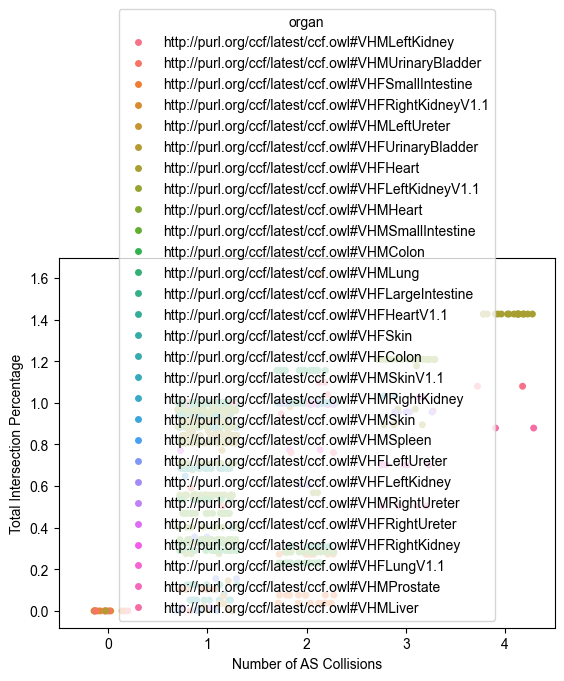

In [15]:
# Create a custom color palette
custom_palette = sns.color_palette("Dark2")

# define strip plot
g = sns.stripplot(data=df_intersections, x='number_of_AS_collisions',
                y='total_intersection_percentage', hue='organ', jitter=0.3)

# Set the style of the plot
# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
sns.set_style("whitegrid")

# change width
sns.set_theme(rc={'figure.figsize': (11.7, 8.27)})

# Set labels
g.set(xlabel="Number of AS Collisions", ylabel="Total Intersection Percentage")

# Move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Show the plot
plt.show()

With facet

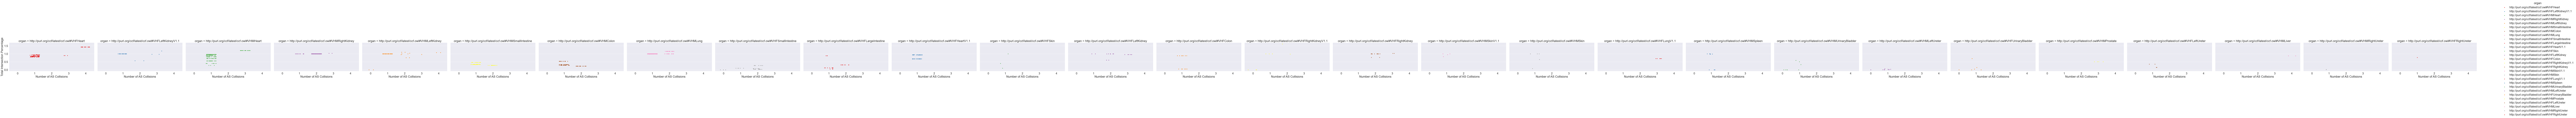

In [ ]:
# Create a custom color palette
custom_palette = sns.color_palette("Set1")

# set font size
sns.set_theme(font_scale=2)

# Get order
categories_order = sorted(df_intersections['number_of_AS_collisions'].unique())

# Create FacetGrid
g = sns.FacetGrid(
    df_intersections,
    col='organ',
    hue='organ',
    palette=custom_palette,
    height=5,
    aspect=2
)

# Set the style of the plot
# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
sns.set_style("whitegrid")

# Create a scatter plot
g.map(sns.stripplot, 'number_of_AS_collisions',
      'total_intersection_percentage', jitter=0.3, order = categories_order)

# Set labels
g.set(xlabel="Number of AS Collisions", ylabel="Total Intersection Percentage")

# Add a legend
g.add_legend()

# Show the plot
plt.show()

## Check for AS-AS collisions

In [ ]:
query = '''
PREFIX cc: <http://creativecommons.org/ns#>
#+ summary: Table S2
#+ description: Anatomical Structures in HRA, their volume, and predicted CT populations

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX ASCTB-TEMP: <https://purl.org/ccf/ASCTB-TEMP_>
PREFIX CL: <http://purl.obolibrary.org/obo/CL_>
PREFIX FMA: <http://purl.org/sig/ont/fma/fma>
PREFIX UBERON: <http://purl.obolibrary.org/obo/UBERON_>
PREFIX ccf: <http://purl.org/ccf/>
PREFIX CCF: <https://purl.humanatlas.io/graph/ccf>
PREFIX HRApop: <https://purl.humanatlas.io/graph/hra-pop>
PREFIX hra-pop: <https://purl.humanatlas.io/graph/hra-pop#>
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX hubmap: <https://entity.api.hubmapconsortium.org/entities/>
PREFIX rui: <http://purl.org/ccf/1.5/>

SELECT DISTINCT ?organ ?organ_id ?as_label ?as_3d_id ?scene_node ?as_volume 
FROM HRApop:
FROM CCF:
WHERE {
  {
    SELECT ?organ ?as_label (SAMPLE(?as_3d_id) as ?as_3d_id) (SAMPLE(?scene_node) as ?scene_node) (AVG(?as_volume) as ?as_volume)
    WHERE {
      ?rui_location a ccf:SpatialEntity .
      ?rui_location ccf:has_collision_summary [
          ccf:has_collision_item [
            ccf:as_id ?as_id ;
            ccf:as_label ?as_label ;
            ccf:as_volume ?as_volume ;
			ccf:as_3d_id ?as_3d_id ;
            ccf:has_reference_organ ?ref_organ ;
          ]
      ] .
      ?as_3d_id ccf:has_object_reference [
      	ccf:file_subpath ?scene_node ;
      ] .
      BIND (REPLACE(REPLACE(REPLACE(STR(?ref_organ), "http://purl.org/ccf/latest/ccf.owl#", ""), "Colon", "LargeIntestine"), "V1.1", "") as ?organ)
    }
    GROUP BY ?organ ?as_label
  }

  {
    SELECT ?organ ?organ_id
    WHERE {
      ?ref_organ ccf:representation_of ?organ_iri .

      BIND (REPLACE(REPLACE(STR(?organ_iri), 'http://purl.obolibrary.org/obo/UBERON_', 'UBERON:'), 'http://purl.org/sig/ont/fma/fma', 'FMA:') as ?organ_id)
      BIND (REPLACE(REPLACE(REPLACE(STR(?ref_organ), "http://purl.org/ccf/latest/ccf.owl#", ""), "Colon", "LargeIntestine"), "V1.1", "") as ?organ)
    }
  }
  

}
ORDER BY ?organ ?as_label

'''

In [ ]:
request = {"query": query}
# use only application/json in format, any other formats will result in errors.
try:
    # help(api_instance.sparql_post)
    api_response = api_instance.sparql_post(
        sparql_query_request=request, format='application/json')
    pprint(api_response)
except hra_api_client.ApiException as e:
    print("Exception when calling DefaultApi->sparql_post: %s\n" % e)

{'head': {'vars': ['organ',
                   'organ_id',
                   'as_label',
                   'as_3d_id',
                   'scene_node',
                   'as_volume']},
 'results': {'bindings': [{'as_3d_id': {'type': 'uri',
                                        'value': 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_papillary_muscle_of_heart_posmed'},
                           'as_label': {'datatype': 'http://www.w3.org/2001/XMLSchema#string',
                                        'type': 'literal',
                                        'value': 'Posteromedial head of '
                                                 'posterior papillary muscle '
                                                 'of left ventricle'},
                           'as_volume': {'datatype': 'http://www.w3.org/2001/XMLSchema#double',
                                         'type': 'literal',
                                         'value': '4401.499'},
                   

In [ ]:
# get as_3d_id

unique_as_3d_id_hra_pop = set()

for item in api_response['results']['bindings']:
  unique_as_3d_id_hra_pop.add(item['as_3d_id']['value'])
  
pprint(unique_as_3d_id_hra_pop)

{'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_ascending_colon',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_caecum',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_descending_colon',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_diaphragmatic_surface_of_spleen',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_ascending',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_descending',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_horizontal',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_superior',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_fat_R',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_fundus_of_urinary_bladder_base',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_hilum_of_kidney_L',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_hilum_of_spleen',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_ileum',
 'http:

In [ ]:
# load CSV from https://github.com/hubmapconsortium/hra-glb-mesh-collisions

as_as_collisions = pd.read_csv("data/collision_results.csv")
# pprint(as_as_collisions)

df_as_mesh = pd.DataFrame(as_as_collisions)

df_as_mesh


# Initialize a list to store results
check_result = []

# Apply a lambda function that checks if any substring in the set is part of the value
df_as_mesh['in_hra_pop'] = df_as_mesh['source'].apply(
    lambda x: any(substring in x for substring in unique_as_3d_id_hra_pop))

df_as_mesh

df_as_mesh.to_csv("output/df_as_mesh.csv")